### In this notebook we will binary-classify handwritten digits from the MNIST dataset (0 and 1). We will be using the logistic function and the backpropagation algorithm

**NOTE:**
#### For this code , you will need to download tensorflow (to easliy use the mnist dataset) for your OS.  
Follow the steps in the links below:  
##### https://www.tensorflow.org/install/pip#virtual-environment-install 
#### It is recommended to download tensorflow in a python virtual environment , hence you will need to install all the packages(like pandas, matplotlib) and jupyter notebook in the virtual environment.  
#### You would also need to **link** the tensorflow install to your jupyter notebook. Run the script below:  
#### python -m ipykernel install --user --name (name-of-virtual-environment) --display-name "Python 3.6 (tensorflow)"  
#### After this just choose the "Python 3.6(tensorflow)" kernel 

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist

### We will first define some helper functions

In [9]:
def get_data():
    """
    Returns (x_train, y_train), (x_test, y_test)
    Only examples that are either hand written 0s or 1s are kept
    All image examples are normalized (divided by 255.)
    """
    def extract_zeros_and_ones(x, y):
        i_zeros = np.where(y == 0)
        i_ones = np.where(y == 1)
        x_zeros = x[i_zeros]
        x_ones = x[i_ones]
        x = np.concatenate((x_zeros, x_ones), axis=0)
        y = np.array([0] * x_zeros.shape[0] + [1] * x_ones.shape[0])
        return x/255, y 
    print('Loading data..')
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, y_train = extract_zeros_and_ones(x_train, y_train)
    x_test, y_test = extract_zeros_and_ones(x_test, y_test)
    print('Done.')
    return (x_train, y_train), (x_test, y_test)

In [3]:
def get_random_batch(x, y, batch_size):
    """
    Returns examples, labels randomly selected
    from given x and y
    """
    num_features = x.shape[1] * x.shape[1] # 28*28 = 784
    num_total = x.shape[0]
    # Examples are unrolled
    X = np.zeros((batch_size, num_features))
    Y = np.zeros((batch_size, 1))

    indices = np.random.randint(0, num_total, batch_size) # (lower-limit,high,size)
    
    for i, index in enumerate(indices): # i is the count and index is the iterable variable
        X[i] = np.reshape(x[index], (num_features,))
        Y[i] = np.array(y[index])

    return X, Y

In [16]:
def show_example(example, label, dim=(28, 28)):
    """
    Displays a single example and label.
    If example is already unrolled from (28, 28) to (784,), it will be reshaped first.
    """
    example = np.squeeze(example)
    label = np.squeeze(label)
    if example.shape != dim:
        example = example.reshape(dim)
    plt.imshow(example, cmap='binary')
    plt.xlabel('Label: ' + str(int(label)))
    plt.show()

In [51]:
def show_ten_examples(examples, labels, preds):
    """
    Display 10 examples along with their labels.
    If the labels are same as predictions, they are displayed in green.
    If the labels and predictions are different, they are displayed in red.
    """
    plt.figure(figsize=(8, 4))
    for i in range(0, 10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.reshape(examples[i], (28, 28)), cmap='binary')
        plt.xticks([]) # They allow to remove the marking on the axis of the plot
        plt.yticks([])
        y = int(np.squeeze(labels[i]))
        p = int(np.squeeze(preds[i]))
        plt.xlabel(str(p), color='green' if y == p else 'red')
    plt.show()

In [18]:
def plot_metrics(model):
    """
    Plot validation accuracy and validation loss during model training.
    """
    plt.figure(figsize=(12, 4))

    accuracies = model.accuracies
    losses = model.losses
    iterations = len(losses)

    plt.subplot(1, 2, 1)
    plt.plot(range(iterations), accuracies, 'r-')
    plt.ylim([0., 1.])
    plt.ylabel('Accuracy')
    plt.xlabel('Iterations')
    plt.title('Acc: {:.3f}'.format(accuracies[-1]))

    plt.subplot(1, 2, 2)
    plt.plot(range(iterations), losses, 'b-')
    plt.ylabel('Loss')
    plt.xlabel('Iterations')
    plt.title('Loss: {:.3f}'.format(losses[-1]))

    plt.show()

In [19]:
# Hyper-Parameters
learning_rate = 0.3
batch_size = 300
iterations = 50

## Understanding the data

In [20]:
(X_train,Y_train) , (X_test,Y_test) = get_data()

Loading data..
Done.


In [21]:
print('Shape of X_train:', X_train.shape)
print('Shape of Y_train:', Y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of Y_test:', Y_test.shape)

Shape of X_train: (12665, 28, 28)
Shape of Y_train: (12665,)
Shape of X_test: (2115, 28, 28)
Shape of Y_test: (2115,)


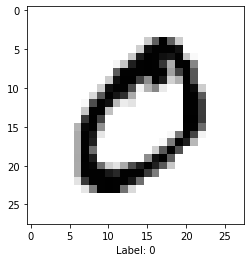

In [22]:
show_example(X_train[0],Y_train[0])

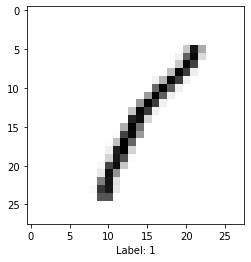

In [23]:
show_example(X_train[-1],Y_train[-1])

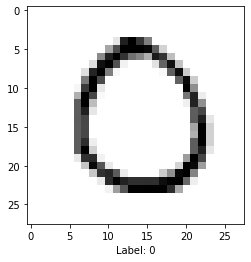

shape of digit:  (1, 784)


In [25]:
# Now we will generate a random batch of examples
X_batch , Y_batch = get_random_batch(X_test,Y_test,1)
show_example(X_batch,Y_batch) 
# Run the cell multiple times and you will notice that the digits are random 
print('shape of digit: ',X_batch.shape)

The shape is (1,784) as it is a single entry in the matrix of all examples  
784 is actually 28x28 (which is the pixel size). Each element is a value b/w 0-255 for that pixel.  

Random batch of 10 examples


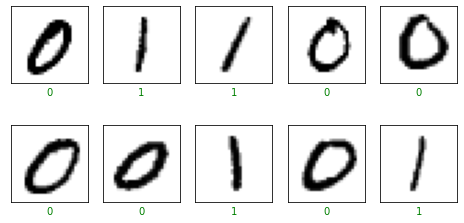

In [29]:
print('Random batch of 10 examples')
X_batch, Y_batch = get_random_batch(X_train, Y_train, 10)
show_ten_examples(X_batch, Y_batch,Y_batch)

## Creating our Model

In [30]:
class LogisticModel:
    def __init__(self, num_features):
        self.W = np.reshape(np.random.randn((num_features)), (num_features, 1))
        self.b = np.zeros((1, 1))
        self.num_features = num_features
        self.losses = []
        self.accuracies = []
        
    def summary(self):
        print('=================================')
        print('Number of features:', self.num_features)
        print('Shape of weights:', self.W.shape)
        print('Shape of biases:', self.b.shape)
        print('=================================')
        
model = LogisticModel(num_features=784)
model.summary()

Number of features: 784
Shape of weights: (784, 1)
Shape of biases: (1, 1)


In [50]:
class LogisticModel(LogisticModel):
    def _forward_pass(self, X, Y=None):
        batch_size = X.shape[0]
        Z = np.dot(X, self.W) + self.b
        A = 1. / (1. + np.exp(-Z)) # sigmoid function
        loss = float(1e5)
        if Y is not None:
            loss = -1 * np.sum(np.dot(np.transpose(Y), np.log(A))+
                               np.dot(np.transpose(1-Y), np.log(1-A)))
            loss /= batch_size
        return A, loss
    
    def _backward_pass(self, A, X, Y):
        batch_size = X.shape[0]
        dZ = A - Y
        dW = np.dot(np.transpose(X), dZ)/batch_size
        db = np.sum(dZ)/batch_size
        return dW, db
     
    def _update_params(self, dW, db, lr):
        self.W -= lr * dW
        self.b -= lr * db
    
    def predict(self, X, Y=None):
        A, loss = self._forward_pass(X, Y)
        Y_hat = A > 0.5
        return np.squeeze(Y_hat), loss
    
    def evaluate(self, X, Y):
        Y_hat, loss = self.predict(X, Y)
        accuracy = np.sum(Y_hat == np.squeeze(Y)) / X.shape[0]
        return accuracy, loss
    

### Untrained Model

In [38]:
model = LogisticModel(num_features=784)

model.summary()
X,Y = get_random_batch(X_train,Y_train,batch_size)
acc , loss = model.evaluate(X,Y)
print('Untrained model accuracy: {}, loss:{}'.format(acc, loss))     

Number of features: 784
Shape of weights: (784, 1)
Shape of biases: (1, 1)
Untrained model accuracy: 0.26666666666666666, loss:3.764862316234756


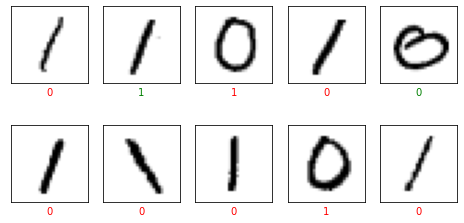

In [39]:
X,Y = get_random_batch(X_train,Y_train,10)
preds,_ = model.predict(X,Y)
show_ten_examples(X,Y,preds)

### Training Model

In [40]:
class LogisticModel(LogisticModel):
    def train(self, batch_size, get_batch, lr, iterations, X_train, Y_train, X_test, Y_test):

        print('Training..')
        self.accuracies = []
        self.losses = []
        
        for i in range(0, iterations):
            X, Y = get_batch(X_train, Y_train, batch_size)
            A, _ = self._forward_pass(X, Y)  
            dW, db = self._backward_pass(A, X, Y)
            self._update_params(dW, db, lr)
            
            X, Y = get_batch(X_test, Y_test, batch_size)
            val_acc, val_loss = self.evaluate(X, Y)
            self.accuracies.append(val_acc)
            self.losses.append(val_loss)
            
            print('Iter: {}, Val Acc: {:.3f}, Val Loss: {:.3f}'.format(i, val_acc, val_loss))
            
        print('Training finished.')

## Results

In [53]:
model = LogisticModel(num_features=784)

X, Y = get_random_batch(X_test, Y_test, batch_size)
print('Before training performance:', model.evaluate(X, Y))
model.train(
    batch_size,
    get_random_batch,
    learning_rate,
    iterations,
    X_train, Y_train,
    X_test, Y_test
)
print('After training performance:', model.evaluate(X, Y))

Before training performance: (0.72, 1.1106354466592845)
Training..
Iter: 0, Val Acc: 0.860, Val Loss: 0.647
Iter: 1, Val Acc: 0.883, Val Loss: 0.593
Iter: 2, Val Acc: 0.890, Val Loss: 0.504
Iter: 3, Val Acc: 0.927, Val Loss: 0.418
Iter: 4, Val Acc: 0.947, Val Loss: 0.325
Iter: 5, Val Acc: 0.913, Val Loss: 0.369
Iter: 6, Val Acc: 0.927, Val Loss: 0.303
Iter: 7, Val Acc: 0.917, Val Loss: 0.388
Iter: 8, Val Acc: 0.940, Val Loss: 0.256
Iter: 9, Val Acc: 0.937, Val Loss: 0.279
Iter: 10, Val Acc: 0.907, Val Loss: 0.304
Iter: 11, Val Acc: 0.930, Val Loss: 0.203
Iter: 12, Val Acc: 0.947, Val Loss: 0.199
Iter: 13, Val Acc: 0.947, Val Loss: 0.148
Iter: 14, Val Acc: 0.940, Val Loss: 0.166
Iter: 15, Val Acc: 0.940, Val Loss: 0.189
Iter: 16, Val Acc: 0.953, Val Loss: 0.124
Iter: 17, Val Acc: 0.950, Val Loss: 0.130
Iter: 18, Val Acc: 0.957, Val Loss: 0.173
Iter: 19, Val Acc: 0.970, Val Loss: 0.094
Iter: 20, Val Acc: 0.933, Val Loss: 0.191
Iter: 21, Val Acc: 0.943, Val Loss: 0.139
Iter: 22, Val Acc: 

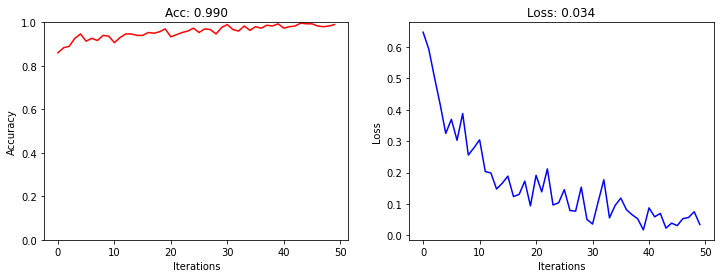

In [54]:
plot_metrics(model)

Final Predictions


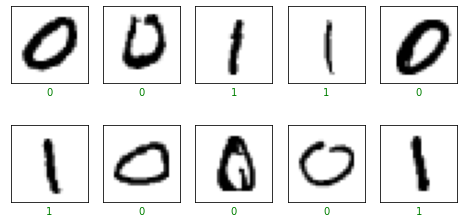

In [55]:
print('Final Predictions')
X,Y = get_random_batch(X_test,Y_test,10)
preds,_ = model.predict(X,Y)
show_ten_examples(X,Y,preds)